# Chest X-ray Analysis for Pneumonia Detection

### Team : Final Project 16
| Student No  | First Name                  | Last Name     |
|-------------|-----------------------------|---------------|
| 9016986     | Keerthi                     | Gonuguntla    |
| 8965985     | Pradeepti                   | Kasam         |

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### **Problem Definition**

Pneumonia, a severe lung infection, can be life-threatening if not diagnosed and treated promptly.

Chest X-rays are a primary diagnostic tool, but interpreting them requires specialized expertise, which may not always be readily available.

This creates a need for an automated, accurate method to assist in the detection of pneumonia.

**Goal**

To Develop a machine learning model that classifies chest X-ray images to detect the presence or absence of pneumonia.

The aim is to provide a reliable diagnostic aid to healthcare professionals, enhancing diagnostic speed and accuracy.

#### **Kaggle Dataset**

[Chest X-Ray Analysis for pneumonia Detection](https://www.kaggle.com/datasets/damingo1/pneumonia-detection)

initial dataset ratios

train - 89%

test - 10.99%

val - 0.003%

In [34]:
#importing required libraries
import os
import shutil
from pathlib import Path
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D,MaxPooling2D, Flatten, Dense, Dropout, Input,GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix, precision_recall_curve, classification_report, average_precision_score

In [3]:
#check current working directory

import os

# Get the current working directory
print("Current Directory:", os.getcwd())

os.chdir('/content/drive/MyDrive/Colab Notebooks')

print("Current Directory:", os.getcwd())


Current Directory: /content
Current Directory: /content/drive/MyDrive/Colab Notebooks


combining the train ,test and val data to perform preprocessing

In [5]:
# Paths to original datasets
train_path = "chest_xray/train"
test_path = "chest_xray/test"
val_path = "chest_xray/val"

# Combined dataset path
combined_dataset_path = "combined_dataset"
normal_path = os.path.join(combined_dataset_path, "NORMAL")
pneumonia_path = os.path.join(combined_dataset_path, "PNEUMONIA")

# Create folders if they don't exist
os.makedirs(normal_path, exist_ok=True)
os.makedirs(pneumonia_path, exist_ok=True)

# Function to copy and rename files
def copy_and_rename_images(source_dir, target_dir, category):
    source_category_path = os.path.join(source_dir, category)
    target_category_path = os.path.join(target_dir, category)

    # Ensure the target folder exists
    os.makedirs(target_category_path, exist_ok=True)

    # Get the current count of files in the target directory to avoid overwriting
    current_count = len(os.listdir(target_category_path))

    # Enumerate files and rename them
    for idx, file_name in enumerate(os.listdir(source_category_path), start=current_count + 1):
        source_file = os.path.join(source_category_path, file_name)
        target_file = os.path.join(target_category_path, f"{category}_{idx:03d}.jpeg")

        # Copy the file
        shutil.copy(source_file, target_file)

# Process train, test, and val directories
for category in ["NORMAL", "PNEUMONIA"]:
    for source_dir in [train_path, test_path, val_path]:
        copy_and_rename_images(source_dir, combined_dataset_path, category)

print("Datasets combined and renamed successfully!")


Datasets combined and renamed successfully!


#### Exploratory Data Analysis

1. Image count per category

In [6]:
data_dir = "combined_dataset"

categories = ["NORMAL", "PNEUMONIA"]
for category in categories:
    path = os.path.join(data_dir, category)
    print(f"Number of {category} images: {len(os.listdir(path))}")


Number of NORMAL images: 1593
Number of PNEUMONIA images: 4292


2. Image Visualization

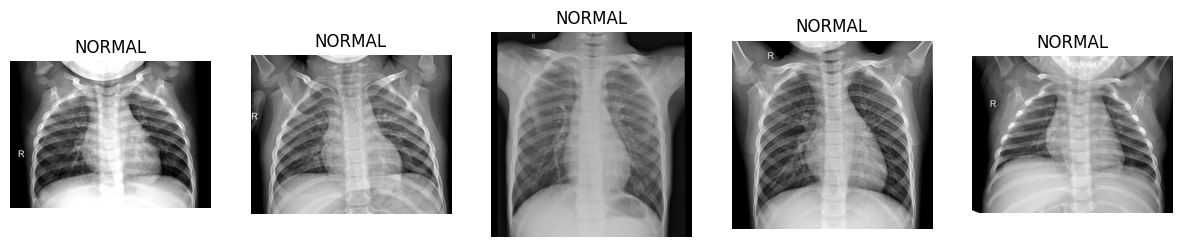

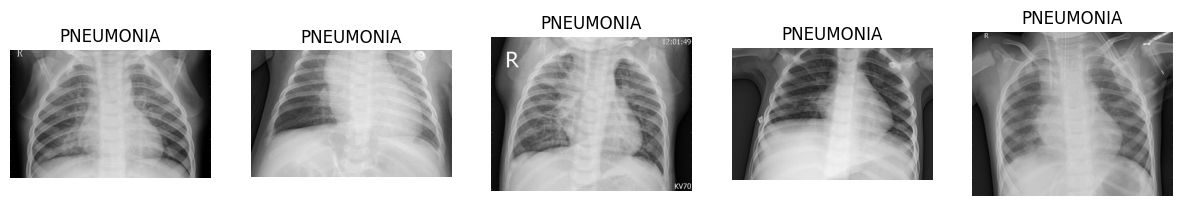

In [7]:
import matplotlib.pyplot as plt
import cv2
import random

def show_sample_images(category, data_dir, num_images=5):
    path = os.path.join(data_dir, category)
    images = random.sample(os.listdir(path), num_images)
    plt.figure(figsize=(15, 5))
    for i, img_name in enumerate(images):
        img_path = os.path.join(path, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(category)
        plt.axis('off')
    plt.show()

for category in categories:
    show_sample_images(category,data_dir)

3. Class Distribution


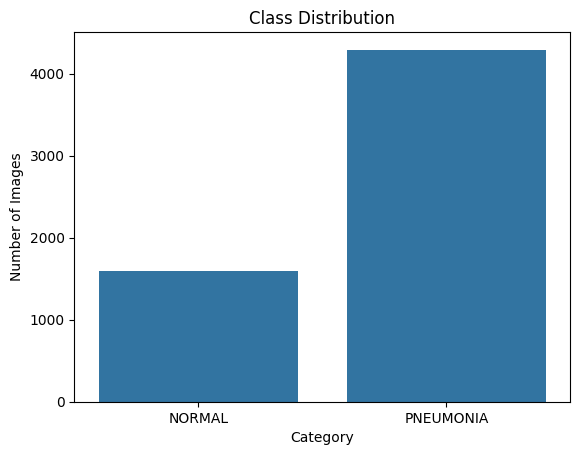

In [8]:
import seaborn as sns

class_counts = {category: len(os.listdir(os.path.join(data_dir, category))) for category in categories}

sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
plt.title("Class Distribution")
plt.xlabel("Category")
plt.ylabel("Number of Images")
plt.show()

4. Image Dimensions



In [9]:
import pandas as pd
image_shapes = []
for category in categories:
    path = os.path.join(data_dir, category)
    for img_name in os.listdir(path):
        img_path = os.path.join(path, img_name)
        img = cv2.imread(img_path)
        if img is not None:
            image_shapes.append(img.shape[:2])  # height, width

image_shapes = pd.DataFrame(image_shapes, columns=['Height', 'Width'])
print(image_shapes.describe())

            Height        Width
count  5885.000000  5885.000000
mean    970.848258  1328.390144
std     382.962327   363.243729
min     127.000000   384.000000
25%     688.000000  1056.000000
50%     888.000000  1284.000000
75%    1187.000000  1560.000000
max    2713.000000  2916.000000


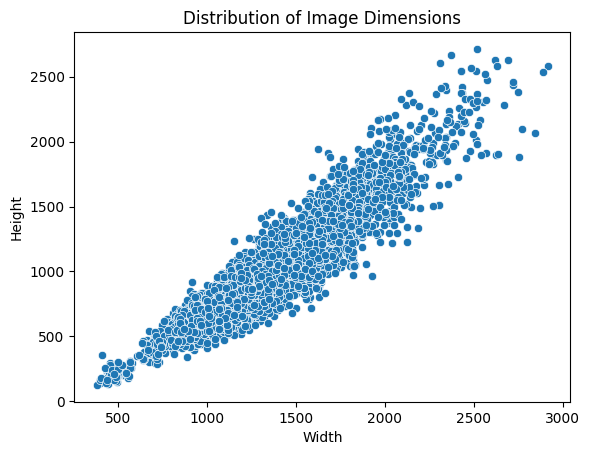

In [43]:
sns.scatterplot(x="Width", y="Height", data=image_shapes)
plt.title("Distribution of Image Dimensions")
plt.xlabel("Width")
plt.ylabel("Height")
plt.show()

Positive Correlation:

The plot shows a strong positive correlation between width and height, meaning larger images in terms of width tend to have larger heights as well.

5. Aspect Ratios

count    5885.000000
mean        1.443171
std         0.254401
min         0.835391
25%         1.261745
50%         1.416058
75%         1.585714
max         3.378788
Name: Aspect Ratio, dtype: float64


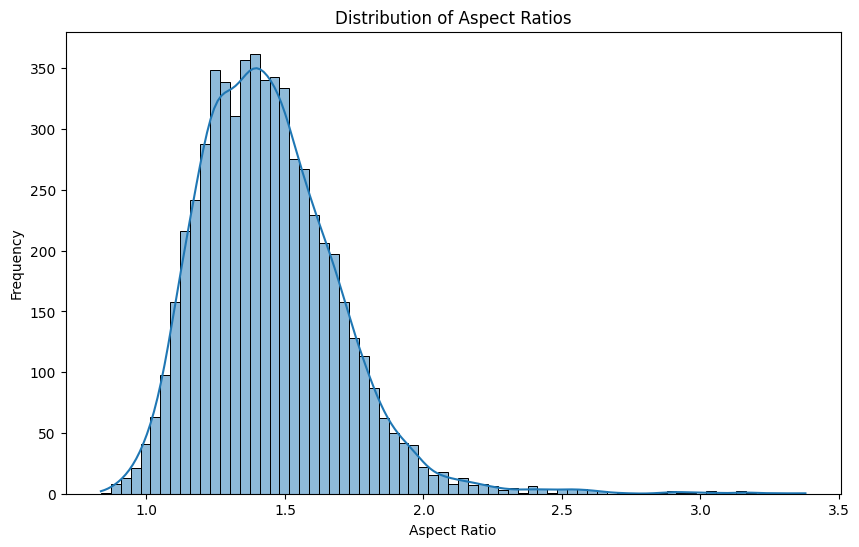

In [42]:
# Calculate aspect ratios
image_shapes['Aspect Ratio'] = image_shapes['Width'] / image_shapes['Height']

# Display aspect ratio statistics
print(image_shapes['Aspect Ratio'].describe())

# Plot aspect ratio distribution
plt.figure(figsize=(10, 6))
sns.histplot(image_shapes['Aspect Ratio'], kde=True)
plt.title('Distribution of Aspect Ratios')
plt.xlabel('Aspect Ratio')
plt.ylabel('Frequency')
plt.show()

The majority of images have aspect ratios around 1.5, suggesting that many images resemble a 3:2 format, commonly used in photography. The skew towards higher aspect ratios indicates fewer wide or elongated images.

#### **Data Preprocessing**

1. To remove corrupted images

In [11]:
combined_dataset_path = "combined_dataset"
normal_path = os.path.join(combined_dataset_path, "NORMAL")
pneumonia_path = os.path.join(combined_dataset_path, "PNEUMONIA")
# Function to clean data by removing duplicates and corrupted images
def clean_data(dataset_path):
    image_files = []
    for category in ["NORMAL", "PNEUMONIA"]:
        category_path = os.path.join(dataset_path, category)
        for file_name in os.listdir(category_path):
            file_path = os.path.join(category_path, file_name)
            try:
                img = load_img(file_path)
                img.verify()  # Verifies that the image is not corrupted
                image_files.append(file_path)
            except Exception as e:
                print(f"Corrupted or invalid image: {file_path}")
                os.remove(file_path)  # Remove corrupted image
    return image_files

# Clean the combined dataset
image_count_before_cleaning = len(os.listdir(normal_path)) + len(os.listdir(pneumonia_path))
print("Image count before cleaning:", image_count_before_cleaning)
image_files = clean_data(combined_dataset_path)
print("Image count after cleaning:", len(image_files))

if len(image_files) == image_count_before_cleaning:
    print("No corrupted images found!")

Image count before cleaning: 5885
Image count after cleaning: 5885
No corrupted images found!


2. Split Data into train ,validation and test in ratios

   train - 60%

   test - 20%

   val - 20%

In [12]:
base_path = r"combined_dataset"
categories = ["NORMAL", "PNEUMONIA"]
splits = ["train", "test", "val"]
output_dir = os.path.join("Final_DataSet")

#Split ratio of the dataset
#dataset is split into 60% train and 40% (test and validation)
train_ratio = 0.6
test_val_ratio = 0.4
#test and validation are split into 50% each
test_ratio = 0.5

# Initializing counters for the split sizes
split_sizes = {"train": 0, "test": 0, "val": 0}

# Initializing total image counters
total_normal_images = 0
total_pneumonia_images = 0

# Creating output directories for splitting the data
for split in splits:
    for category in categories:
        os.makedirs(os.path.join(output_dir, split, category), exist_ok=True)

# Printing the number of images before splitting
print("Before splitting:")
for category in categories:
    category_path = os.path.join(base_path, category)
    if not os.path.exists(category_path):
        print(f"Directory not found: {category_path}, skipping.")
        continue
    # Get list of all image files in the category folder
    files = os.listdir(category_path)
    files = [f for f in files if os.path.isfile(os.path.join(category_path, f))]
    category_image_count = len(files)
    # Add to total counts
    if category == "NORMAL":
        total_normal_images = category_image_count
    elif category == "PNEUMONIA":
        total_pneumonia_images = category_image_count
    print(f"{category.capitalize()} image count: {category_image_count}")
# Printing the total images in both categories before splitting
total_images = total_normal_images + total_pneumonia_images
print(f"Total image count: {total_images}")

# Splitting the images into train, test, and validation
for category in categories:
    category_path = os.path.join(base_path, category)
    if not os.path.exists(category_path):
        print(f"Directory not found: {category_path}, skipping.")
        continue
    # Get list of all image files in the category folder
    files = os.listdir(category_path)
    files = [f for f in files if os.path.isfile(os.path.join(category_path, f))]
    # Splitting the data into train and temp(for test and validation)
    train_files, temp_files = train_test_split(files, test_size=test_val_ratio, random_state=42)
    # Splitting temp_files into test and validation sets
    val_files, test_files = train_test_split(temp_files, test_size=test_ratio, random_state=42)
    # Moving files into respective folders and count the number of images
    for file_list, split in [(train_files, "train"), (test_files, "test"), (val_files, "val")]:
        for file in file_list:
            src = os.path.join(category_path, file)
            dst = os.path.join(output_dir, split, category, file)
            # Move the file to the appropriate folder
            shutil.copy(src, dst)
            split_sizes[split] += 1

# Printing the size of each data set
print("\nAfter splitting:")
print(f"Train size: {split_sizes['train']}, Ratio: {split_sizes['train']/total_images*100:.2f}%")
print(f"Test size: {split_sizes['test']}, Ratio: {split_sizes['test']/total_images*100:.2f}%")
print(f"Validation size: {split_sizes['val']}, Ratio: {split_sizes['val']/total_images*100:.2f}%")

Before splitting:
Normal image count: 1593
Pneumonia image count: 4292
Total image count: 5885

After splitting:
Train size: 3530, Ratio: 59.98%
Test size: 1178, Ratio: 20.02%
Validation size: 1177, Ratio: 20.00%


3. Data Augmentation

Found 3530 images belonging to 2 classes.
Found 1177 images belonging to 2 classes.
Found 1178 images belonging to 2 classes.
Sample preprocessed images from the training set:



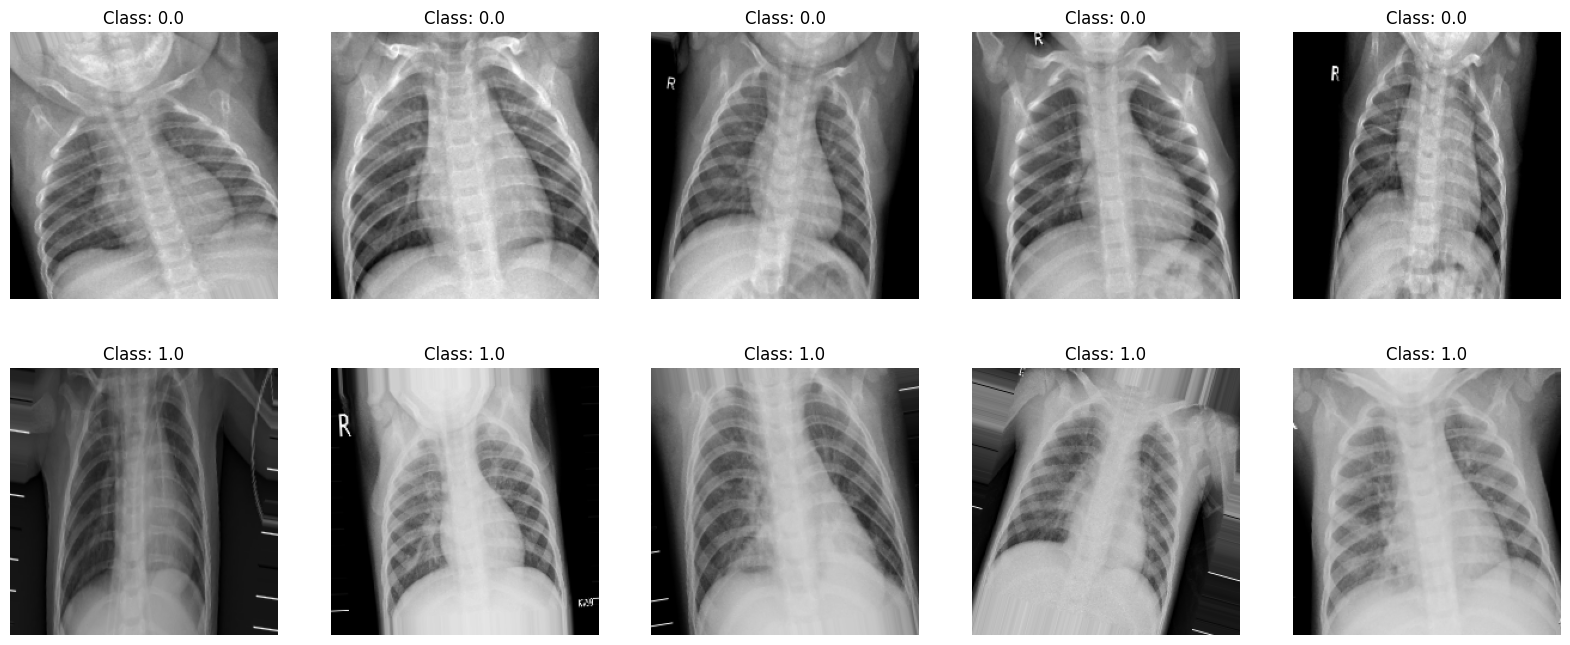

Sample augmented images from the training set:


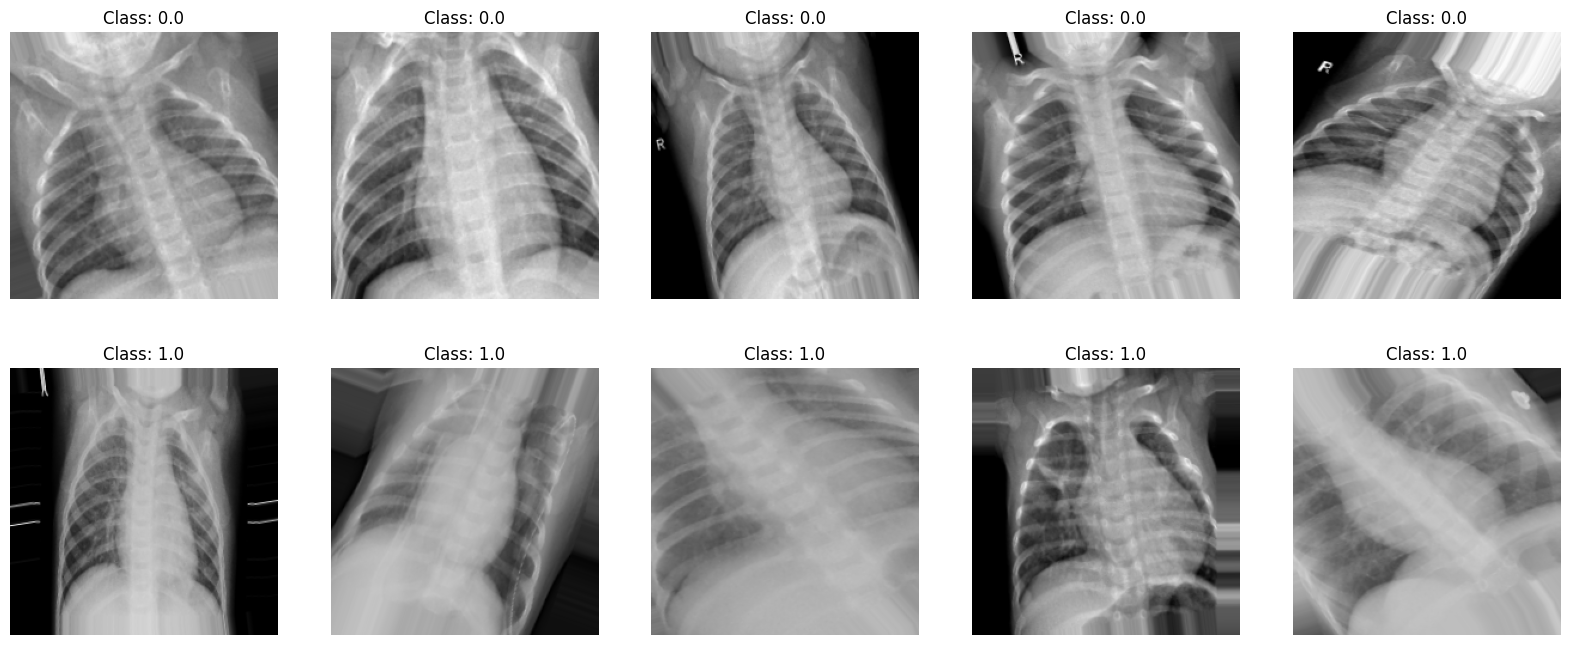

In [13]:
# Defining image dimensions
img_width, img_height = 224, 224

# Creating an ImageDataGenerator for training data with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values to [0,1]
    rotation_range=20,  # Random rotation
    zoom_range=0.2  # Random zoom
)

# Setting up generators for train split
train_generator = train_datagen.flow_from_directory(
    os.path.join("Final_DataSet", 'train'),
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode='binary',
    shuffle=False  # Disabling shuffling to get the same images
)

#Validation data generator without augmentation
val_datagen = ImageDataGenerator(rescale=1./255)
# Setting up generators for validation split
val_generator = val_datagen.flow_from_directory(
    os.path.join("Final_DataSet", 'val'),
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode='binary',
    shuffle=False  # Disabling shuffling to get the same images
)

#Test data generator without augmentation
test_datagen = ImageDataGenerator(rescale=1./255)
# Setting up generators for test split
test_generator = test_datagen.flow_from_directory(
    os.path.join("Final_DataSet", 'test'),
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode='binary',
    shuffle=False  # Disabling shuffling to get the same images
)

# created a Function to display sample images from both classes
def display_images(generator, num_images=5, is_augmented=False):
    plt.figure(figsize=(20, 8))
    images, labels = next(generator)
    class_0_count = class_1_count = 0
    i = 0
    while class_0_count < num_images or class_1_count < num_images:
        if i >= len(images):
            images, labels = next(generator)
            i = 0
        image = images[i]
        label = labels[i]
        if (label == 0 and class_0_count < num_images) or (label == 1 and class_1_count < num_images):
            ax = plt.subplot(2, num_images, (1 if label == 0 else num_images+1) + (class_0_count if label == 0 else class_1_count))
            if is_augmented:
                image = train_datagen.random_transform(image)
            #plt.imshow(image.reshape(img_width, img_height))
            plt.imshow(image)
            plt.title(f"Class: {labels[i]}")
            plt.axis('off')
            if label == 0:
                class_0_count += 1
            else:
                class_1_count += 1
        i += 1
    plt.show() # Displaying the images


# Displaying sample preprocessed and augmented images from the training set
print("Sample preprocessed images from the training set:\n")
display_images(train_generator)
print("Sample augmented images from the training set:")
display_images(train_generator, is_augmented=True)


In [ ]:
model = Sequential([
    Input(shape=(img_width, img_height, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dropout(0.5),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [15]:
# Displaying the model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 18432)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 18432)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       9,437,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,679,041 (36.92 MB)

 Trainable params: 9,679,041 (36.92 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
# Compiling the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [17]:
# Defining the number of epochs
epochs = 20

# Setting up early stopping callback to prevent overfitting
#early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Setting up model checkpoint callback to save the best model
model_checkpoint = ModelCheckpoint('models/best_model.keras', save_best_only=True)


# Training the model
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data= val_generator,
    callbacks=model_checkpoint
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


111/111 ━━━━━━━━━━━━━━━━━━━━ 117s 934ms/step - accuracy: 0.6490 - loss: 1.4498 - val_accuracy: 0.7290 - val_loss: 0.6452
Epoch 2/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 126s 846ms/step - accuracy: 0.7220 - loss: 0.6400 - val_accuracy: 0.7298 - val_loss: 0.5574
Epoch 3/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 103s 890ms/step - accuracy: 0.7166 - loss: 0.7131 - val_accuracy: 0.7927 - val_loss: 0.5097
Epoch 4/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 133s 809ms/step - accuracy: 0.7473 - loss: 0.5750 - val_accuracy: 0.8360 - val_loss: 0.4884
Epoch 5/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 101s 865ms/step - accuracy: 0.7945 - loss: 0.4484 - val_accuracy: 0.8292 - val_loss: 0.4244
Epoch 6/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 95s 818ms/step - accuracy: 0.7869 - loss: 0.4399 - val_accuracy: 0.8352 - val_loss: 0.4355
Epoch 7/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 146s 857ms/step - accuracy: 0.7883 - loss: 0.4682 - val_accuracy: 0.8530 - val_loss: 0.4025
Epoch 8/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 101s 855ms/step - accuracy: 0.8157 - loss: 0.419

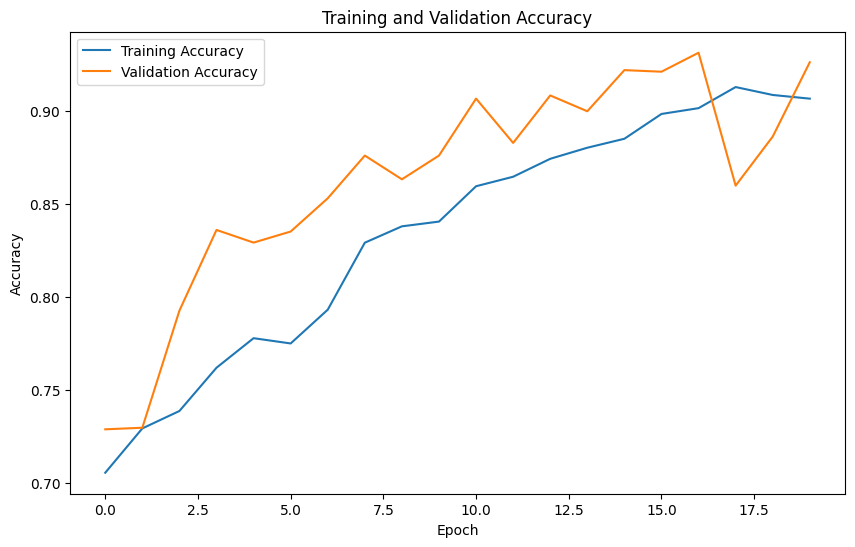

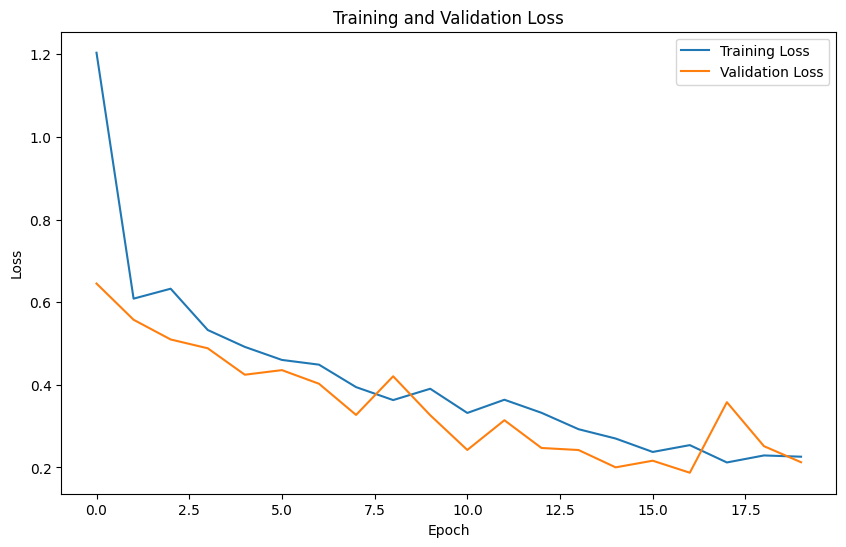

In [18]:
# Plotting the training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Plotting the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


In [32]:
from tensorflow import keras

#Evaluating the model on the test set
test_model_cnn = keras.models.load_model("models/best_model.keras")
#verbose=2 to display the accuracy
test_loss, test_acc = test_model_cnn.evaluate(test_generator, verbose=2)
print(f"Test accuracy: {test_acc:.3f}")

37/37 - 14s - 384ms/step - accuracy: 0.9329 - loss: 0.1805
Test accuracy: 0.933


### 2: Training the VGG16

In [20]:
#Building a VGG16 model
# Load the VGG16 model
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

# Freeze the layers
for layer in vgg16.layers:
    layer.trainable = False

# Adding custom layers
x = Flatten()(vgg16.output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)

# Creating the model
model = Model(vgg16.input, x)


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Compiling the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [22]:
# Displaying the model summary
model.summary()

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 17,926,209 (68.38 MB)

 Trainable params: 3,211,521 (12.25 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [23]:
# Defining the number of epochs
epochs = 20

# Setting up early stopping callback to prevent overfitting
#early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Setting up model checkpoint callback to save the best model

model_checkpoint = ModelCheckpoint('models/best_model_VGG16.keras', save_best_only=True)

# Training the model
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator,
    #callbacks=[early_stopping, model_checkpoint]
    callbacks=model_checkpoint
)

Epoch 1/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 131s 1s/step - accuracy: 0.6219 - loss: 2.5826 - val_accuracy: 0.7290 - val_loss: 0.3615
Epoch 2/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 111s 837ms/step - accuracy: 0.7133 - loss: 0.4447 - val_accuracy: 0.7290 - val_loss: 0.3152
Epoch 3/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 97s 825ms/step - accuracy: 0.6799 - loss: 0.4945 - val_accuracy: 0.7290 - val_loss: 0.3306
Epoch 4/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 142s 840ms/step - accuracy: 0.7512 - loss: 0.3923 - val_accuracy: 0.7290 - val_loss: 0.2892
Epoch 5/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 145s 872ms/step - accuracy: 0.7164 - loss: 0.3985 - val_accuracy: 0.7290 - val_loss: 0.3060
Epoch 6/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 140s 828ms/step - accuracy: 0.7519 - loss: 0.3914 - val_accuracy: 0.7290 - val_loss: 0.2730
Epoch 7/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 139s 815ms/step - accuracy: 0.6825 - loss: 0.4268 - val_accuracy: 0.9108 - val_loss: 0.3342
Epoch 8/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 97s 827ms/step - accuracy: 0.7161 - loss

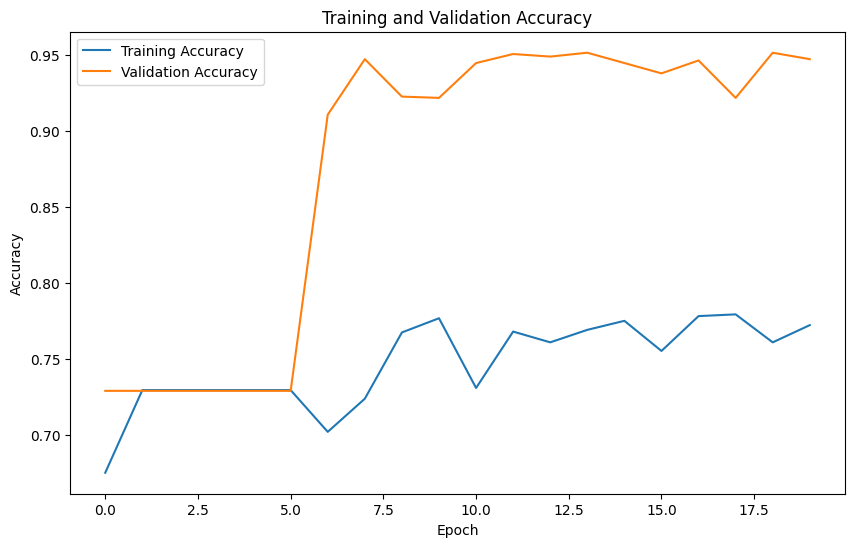

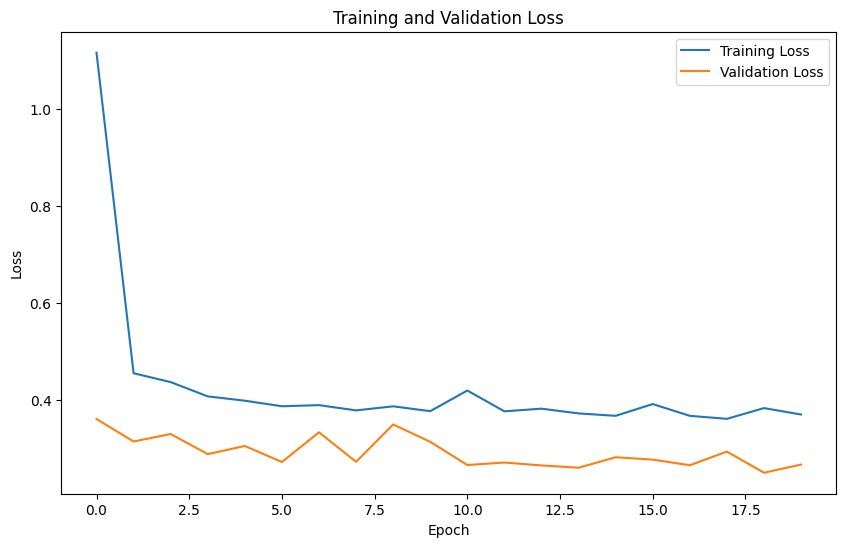

In [24]:
# Plotting the training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Plotting the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [31]:
#Evaluating the model on the test set
test_model_vgg = keras.models.load_model("models/best_model_VGG16.keras")
#verbose=2 to display the accuracy
test_loss, test_acc = test_model_vgg.evaluate(test_generator, verbose=2)
print(f"Test accuracy: {test_acc:.3f}")

37/37 - 16s - 439ms/step - accuracy: 0.9593 - loss: 0.2515
Test accuracy: 0.959


In [26]:
#Extracting the best models for evaluation
cnn_model = keras.models.load_model("models/best_model.keras")
vgg_model = keras.models.load_model("models/best_model_VGG16.keras")

confusion matrix

37/37 ━━━━━━━━━━━━━━━━━━━━ 19s 483ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 17s 446ms/step


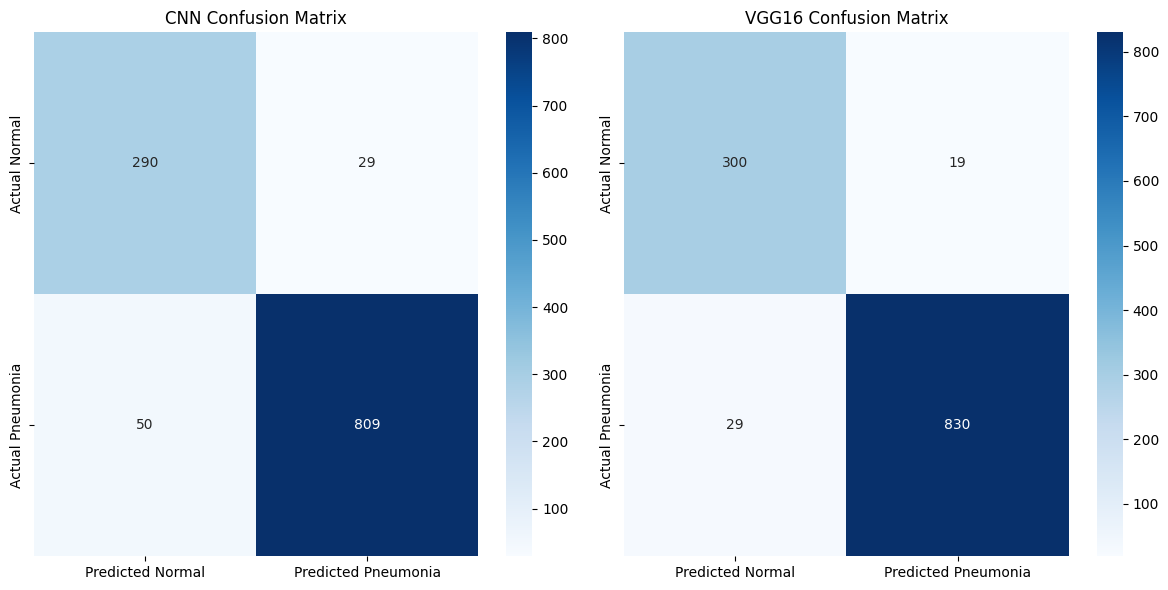

In [36]:
# prompt: #confusion matrix for CNN and vgg16

# Predict on the test set
y_pred_cnn = cnn_model.predict(test_generator)
y_pred_cnn = (y_pred_cnn > 0.5).astype(int)  # Convert probabilities to class labels

y_pred_vgg = vgg_model.predict(test_generator)
y_pred_vgg = (y_pred_vgg > 0.5).astype(int)  # Convert probabilities to class labels

# Get true labels
y_true = test_generator.classes

# Compute confusion matrices
cm_cnn = confusion_matrix(y_true, y_pred_cnn)
cm_vgg = confusion_matrix(y_true, y_pred_vgg)

# Plot confusion matrices
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.heatmap(cm_cnn, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Normal', 'Predicted Pneumonia'],
            yticklabels=['Actual Normal', 'Actual Pneumonia'])
plt.title('CNN Confusion Matrix')

plt.subplot(1, 2, 2)
sns.heatmap(cm_vgg, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Normal', 'Predicted Pneumonia'],
            yticklabels=['Actual Normal', 'Actual Pneumonia'])
plt.title('VGG16 Confusion Matrix')

plt.tight_layout()
plt.show()

The CNN model has 29 false positives and 50 false negatives, indicating slightly more misclassifications compared to the VGG16 model.

The VGG16 model performs better, with only 19 false positives and 29 false negatives, showing improved accuracy in both classes. Overall, VGG16 demonstrates superior performance in correctly classifying pneumonia and normal cases.

classification report

In [37]:
# Classification Reports
print("CNN Classification Report:\n", classification_report(y_true, y_pred_cnn))
print("VGG16 Classification Report:\n", classification_report(y_true, y_pred_vgg))

CNN Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.91      0.88       319
           1       0.97      0.94      0.95       859

    accuracy                           0.93      1178
   macro avg       0.91      0.93      0.92      1178
weighted avg       0.93      0.93      0.93      1178

VGG16 Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.94      0.93       319
           1       0.98      0.97      0.97       859

    accuracy                           0.96      1178
   macro avg       0.94      0.95      0.95      1178
weighted avg       0.96      0.96      0.96      1178



0 - normal 

1-pneumonia

Precision - Recall curve

37/37 ━━━━━━━━━━━━━━━━━━━━ 16s 402ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 15s 388ms/step


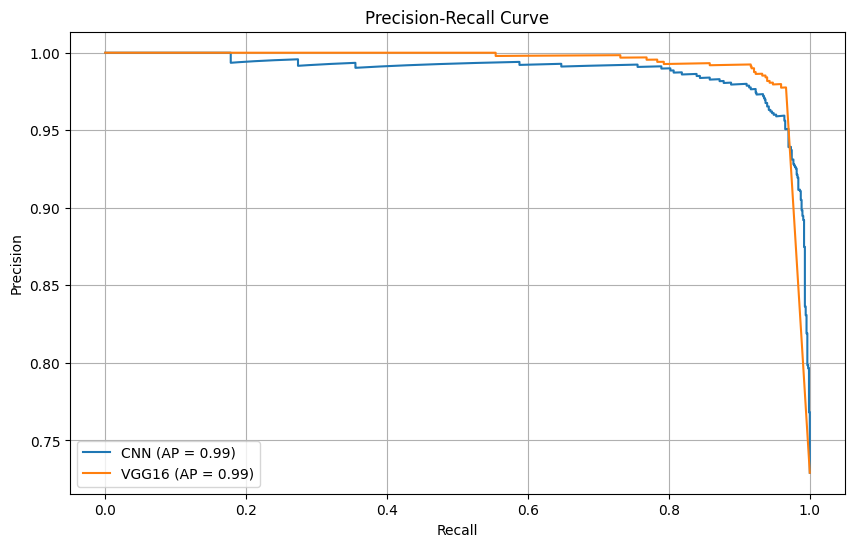

In [38]:
# prompt: #precision recall curve for CNN and VGG16

# Predict probabilities for the positive class (Pneumonia)
y_prob_cnn = cnn_model.predict(test_generator)
y_prob_vgg = vgg_model.predict(test_generator)

# Calculate precision and recall for different thresholds
precision_cnn, recall_cnn, thresholds_cnn = precision_recall_curve(y_true, y_prob_cnn)
precision_vgg, recall_vgg, thresholds_vgg = precision_recall_curve(y_true, y_prob_vgg)

# Calculate average precision score
average_precision_cnn = average_precision_score(y_true, y_prob_cnn)
average_precision_vgg = average_precision_score(y_true, y_prob_vgg)


# Plot the Precision-Recall curves
plt.figure(figsize=(10, 6))
plt.plot(recall_cnn, precision_cnn, label=f'CNN (AP = {average_precision_cnn:.2f})')
plt.plot(recall_vgg, precision_vgg, label=f'VGG16 (AP = {average_precision_vgg:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()

The precision-recall (PR) curve compares the performance of two models: CNN and VGG16. Both models exhibit high precision and recall, as indicated by the curve staying close to the top-right corner and the area under the PR curve (AP = 0.99) being almost perfect. This suggests that both models are highly effective in distinguishing between the positive and negative classes.

Misclassified images

CNN Misclassified Images:
37/37 ━━━━━━━━━━━━━━━━━━━━ 14s 376ms/step


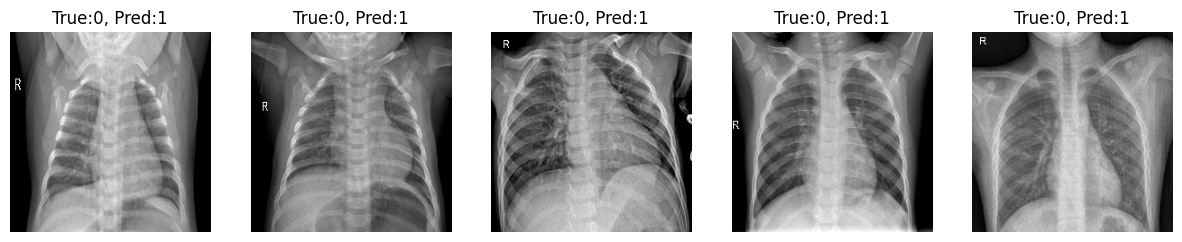


VGG16 Misclassified Images:
37/37 ━━━━━━━━━━━━━━━━━━━━ 18s 434ms/step


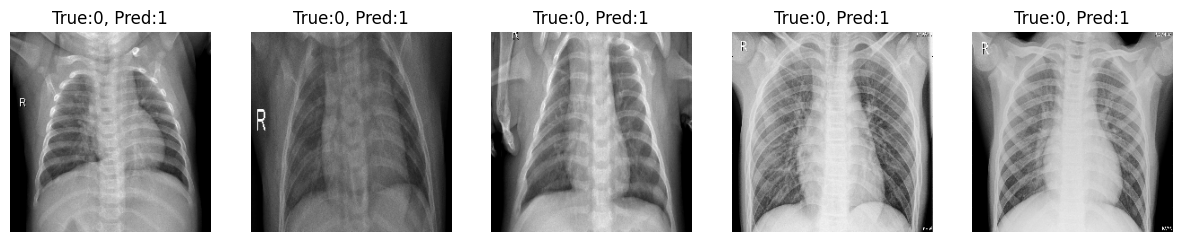

In [41]:
import matplotlib.pyplot as plt
import numpy as np

# Function to display misclassified images
def display_misclassified_images(model, generator, num_images=5):
    y_pred = model.predict(generator)
    y_pred = (y_pred > 0.5).astype(int).flatten()
    y_true = generator.classes
    misclassified_indices = np.where(y_pred != y_true)[0]

    plt.figure(figsize=(15, 5))

    for i, index in enumerate(misclassified_indices[:num_images]):
      img, label = generator[int(index/generator.batch_size)]
      img = img[index%generator.batch_size]
      plt.subplot(1, num_images, i+1)
      plt.imshow(img)
      plt.title(f"True:{y_true[index]}, Pred:{y_pred[index]}")
      plt.axis('off')
    plt.show()


print("CNN Misclassified Images:")
display_misclassified_images(cnn_model, test_generator)

print("\nVGG16 Misclassified Images:")
display_misclassified_images(vgg_model, test_generator)

summary

Overall CNN and VGG16 both have a similar and effective performance , but VGG16 slighly overpowers CNN.